# Building code for NYSM +/-15 day averages
- https://docs.xarray.dev/en/stable/examples/monthly-means.html
- https://docs.xarray.dev/en/stable/generated/xarray.Dataset.rolling.html#xarray.Dataset.rolling

In [658]:
import pandas as pd
import numpy as np
from glob import glob
from datetime import datetime, timedelta
import os
import xarray as xr

#### Read in NYSM data
- Data is saved locally as csv files for each day with file naming convention "20210815.csv"
    - Each day contains all sites with meteorological data saved out every 5 minutes
- Read in each day's dataframe and concatenate into one large dataframe containing all days/sites

In [2]:
# Set paths and the initial date of NYSM data
# nysm_sites = pd.read_csv("/spare11/atm533/data/nysm_sites.csv")
path = "/kt11/ktyle/mesonet/" # use your path
date_init = datetime.strptime('01-01-17', '%m-%d-%y')
days_from_init = 365*5+257 #5+257 # Ex: to read in each day's CSV set to 365*5, we have data through Sep 13, 2022

In [3]:
# create list of strings in the form of "yyyymmdd" to be used for reading in csv datasets
def date_string(date_val):
    return f"{'{:04d}'.format(date_val.year)}{'{:02d}'.format(date_val.month)}{'{:02d}'.format(date_val.day)}"

dates = []
for x in range(0, days_from_init): 
    date = date_string(date_init + timedelta(days = x))
    dates.append(date)
    
# create list of all files to be read in using list of dates (as strings) as defined in previous cell
all_files = []
for day in dates:
    all_files.append(f"{path}{day}.csv")

In [4]:
%%time 

# for each csv file in list, read in the data as a dataframe and append dataframes to list "li"
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

# concatenate all dataframes in list to get one large dataframe for each day
nysm_data = pd.concat(li, axis=0, ignore_index=True)

CPU times: user 2min 17s, sys: 29.7 s, total: 2min 46s
Wall time: 4min 58s


In [5]:
len(li)

2082

In [6]:
# subset dataframe to fields of interest and rename column name

nysm_data = nysm_data[["station", "time", "temp_2m [degC]"]]
nysm_data = nysm_data.rename(columns={"temp_2m [degC]": "temp_2m[C]"})

In [7]:
print(nysm_data.columns)
print(nysm_data[["station", "time"]].nunique())
print(126*599616)
print(nysm_data.shape)

Index(['station', 'time', 'temp_2m[C]'], dtype='object')
station       126
time       599616
dtype: int64
75551616
(75070368, 3)


In [8]:
nysm_data.shape
nysm_data.head()

,station,time,temp_2m[C]
0,ADDI,2017-01-01 00:00:00 UTC,-0.8
1,ADDI,2017-01-01 00:05:00 UTC,-0.7
2,ADDI,2017-01-01 00:10:00 UTC,-0.5
3,ADDI,2017-01-01 00:15:00 UTC,-0.4
4,ADDI,2017-01-01 00:20:00 UTC,-0.2


In [9]:
np.mean(nysm_data[nysm_data['station'] == 'ADDI'][0:288]['temp_2m[C]'])

0.12604166666666652

#### Use xarray's .rolling function to calculate the 15-day rolling average from each date
- First convert the large dataframe of mesonet data into xarray dataset with station and time as the coordinates
- Average by date so that there is one value for each site and date (rather than 288, every 5 mins, per day)
- Find each day's 15-day rolling average, centered around the date (i.e. includes the 7 days prior and after)

In [558]:
%%time

# set station and time to be indices of the df so that the conversion to xarray dataset makes them coordinates
nysm_df = nysm_data.set_index(["station", "time"]) 
print(nysm_data.shape)
# convert to dataset
nysm_ds = nysm_df.to_xarray()

# convert time coordinate of the dataset to datetime format
# NOTE: must be executed twice (last subcomment here by Vinod: https://stackoverflow.com/questions/62572678/xarray-coords-conversion-to-datetime64)
nysm_ds["time"] = pd.DatetimeIndex(nysm_ds["time"].values)
nysm_ds["time"] = pd.DatetimeIndex(nysm_ds["time"].values)

(75070368, 3)
CPU times: user 1min 4s, sys: 2.81 s, total: 1min 7s
Wall time: 1min 7s


In [57]:
nysm_ds

<xarray.Dataset>
Dimensions:     (station: 126, time: 599616)
Coordinates:
  * station     (station) object 'ADDI' 'ANDE' 'BATA' ... 'WHIT' 'WOLC' 'YORK'
  * time        (time) datetime64[ns] 2017-01-01 ... 2022-09-13T23:55:00
Data variables:
    temp_2m[C]  (station, time) float64 -0.8 -0.7 -0.5 -0.4 ... 14.0 13.9 13.9

In [ ]:
# Understand the NANs - 1.3Million NANs
print(nysm_ds.count())
print(75551616 - 74156627 )

In [112]:
ch = nysm_ds.groupby("time.date").count("time")

In [113]:
ch

<xarray.Dataset>
Dimensions:     (station: 126, date: 2082)
Coordinates:
  * station     (station) object 'ADDI' 'ANDE' 'BATA' ... 'WHIT' 'WOLC' 'YORK'
  * date        (date) object 2017-01-01 2017-01-02 ... 2022-09-12 2022-09-13
Data variables:
    temp_2m[C]  (station, date) int64 288 288 288 288 288 ... 288 288 288 288

In [115]:
try1 = ch['temp_2m[C]'].to_numpy()
try2 = try1.flatten()
print(try2[1:6])
tryy = np.isnan(try2)
# try2 = tryy.flatten()
# nanns = np.isnan(try2)
print(np.count_nonzero(tryy))

[288 288 288 288 288]
0


In [59]:
126*599616

75551616

In [88]:
have = nysm_ds.isnull()

In [92]:
ns = nysm_ds.isnull()['temp_2m[C]'].to_numpy()
ns

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [111]:
try1 = nysm_ds['temp_2m[C]'].to_numpy()
try2 = try1.flatten()
print(try2[1:6])
tryy = np.isnan(try2)
# try2 = tryy.flatten()
# nanns = np.isnan(try2)
print(np.count_nonzero(tryy))

[-0.7 -0.5 -0.4 -0.2 -0.2]
1394989


In [80]:
bool_keep = nysm_ds.isnull()['temp_2m[C]']

In [85]:
type(bool_keep)

xarray.core.dataarray.DataArray

In [86]:
newds = nysm_ds.where(bool_keep, drop = False)

In [87]:
newds

<xarray.Dataset>
Dimensions:     (station: 126, time: 599616)
Coordinates:
  * station     (station) object 'ADDI' 'ANDE' 'BATA' ... 'WHIT' 'WOLC' 'YORK'
  * time        (time) datetime64[ns] 2017-01-01 ... 2022-09-13T23:55:00
Data variables:
    temp_2m[C]  (station, time) float64 nan nan nan nan nan ... nan nan nan nan

In [64]:
126*348198

43872948

In [74]:
nysm_ds['temp_2m[C]'].isnull().count()

<xarray.DataArray 'temp_2m[C]' ()>
array(75551616)

In [55]:
nysm_ds

<xarray.Dataset>
Dimensions:     (station: 126, time: 599616)
Coordinates:
  * station     (station) object 'ADDI' 'ANDE' 'BATA' ... 'WHIT' 'WOLC' 'YORK'
  * time        (time) datetime64[ns] 2017-01-01 ... 2022-09-13T23:55:00
Data variables:
    temp_2m[C]  (station, time) float64 -0.8 -0.7 -0.5 -0.4 ... 14.0 13.9 13.9

In [54]:
n = nysm_ds.where(nysm_ds['temp_2m[C]'].isnull(), drop = True)
n

<xarray.Dataset>
Dimensions:     (station: 126, time: 348198)
Coordinates:
  * station     (station) object 'ADDI' 'ANDE' 'BATA' ... 'WHIT' 'WOLC' 'YORK'
  * time        (time) datetime64[ns] 2017-01-01 ... 2022-09-12T13:55:00
Data variables:
    temp_2m[C]  (station, time) float64 nan nan nan nan nan ... nan nan nan nan

In [50]:
n['date']

<xarray.DataArray 'date' (date: 717)>
array(['2017-01-01T00:00:00.000000000', '2017-01-02T00:00:00.000000000',
       '2017-01-03T00:00:00.000000000', ..., '2022-07-25T00:00:00.000000000',
       '2022-08-15T00:00:00.000000000', '2022-08-16T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * date     (date) datetime64[ns] 2017-01-01 2017-01-02 ... 2022-08-16

In [48]:
n['temp_2m[C]']

<xarray.DataArray 'temp_2m[C]' (station: 76, date: 717)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * station  (station) object 'ADDI' 'BATA' 'BEAC' ... 'WGAT' 'WHIT' 'WOLC'
  * date     (date) datetime64[ns] 2017-01-01 2017-01-02 ... 2022-08-16

In [29]:
ds_nans = np.asarray(ds['temp_2m[C]']).isna()

AttributeError: 'numpy.ndarray' object has no attribute 'isna'

In [ ]:
nysm_ds

In [18]:
c = nysm_ds['temp_2m[C]']
print(type(c))
c.count()

<class 'xarray.core.dataarray.DataArray'>


<xarray.DataArray 'temp_2m[C]' ()>
array(74156627)

In [51]:
nysm_ds

<xarray.Dataset>
Dimensions:     (station: 126, time: 599616)
Coordinates:
  * station     (station) object 'ADDI' 'ANDE' 'BATA' ... 'WHIT' 'WOLC' 'YORK'
  * time        (time) datetime64[ns] 2017-01-01 ... 2022-09-13T23:55:00
Data variables:
    temp_2m[C]  (station, time) float64 -0.8 -0.7 -0.5 -0.4 ... 14.0 13.9 13.9

In [117]:
ds

<xarray.Dataset>
Dimensions:     (station: 126, date: 2082)
Coordinates:
  * station     (station) object 'ADDI' 'ANDE' 'BATA' ... 'WHIT' 'WOLC' 'YORK'
  * date        (date) datetime64[ns] 2017-01-01 2017-01-02 ... 2022-09-13
Data variables:
    temp_2m[C]  (station, date) float64 0.126 -1.302 2.219 ... 18.88 20.68 17.11

In [627]:
# get average value by day (removing hour/minute variable and leaving just one value per day)
ds = nysm_ds.groupby("time.date").mean("time", skipna=True)

# convert time coordinate of the dataset to datetime format
ds["date"] = pd.DatetimeIndex(ds["date"].values)
ds["date"] = pd.DatetimeIndex(ds["date"].values)

ds

/knight/anaconda_aug22/envs/aug22_env/lib/python3.10/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in true_divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


<xarray.Dataset>
Dimensions:     (station: 126, date: 2082)
Coordinates:
  * station     (station) object 'ADDI' 'ANDE' 'BATA' ... 'WHIT' 'WOLC' 'YORK'
  * date        (date) datetime64[ns] 2017-01-01 2017-01-02 ... 2022-09-13
Data variables:
    temp_2m[C]  (station, date) float64 0.126 -1.302 2.219 ... 18.88 20.68 17.11

In [607]:
ds.count() 

<xarray.Dataset>
Dimensions:     ()
Data variables:
    temp_2m[C]  int64 259018

In [363]:
# Understand the NANs - 3,300 site_days of nan, meaning that every single entry (5-min wise) was nan for that site and day
# otherwise if there was any non nan value entry for that day, it would have a non-nan avg for that day, see: https://groups.google.com/g/xarray/c/Redmh2tUqL8
print(126*2082)
print(ds.count())
print(262332 - 259018) # 1.2% of site_days are nan

262332
<xarray.Dataset>
Dimensions:     ()
Data variables:
    temp_2m[C]  int64 259018
3314


In [266]:
g['date']

<xarray.DataArray 'date' (date: 5)>
array(['2017-01-30T00:00:00.000000000', '2017-01-31T00:00:00.000000000',
       '2017-02-01T00:00:00.000000000', '2017-02-02T00:00:00.000000000',
       '2017-02-03T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * date     (date) datetime64[ns] 2017-01-30 2017-01-31 ... 2017-02-03

In [265]:
#f = ds.sel(date = slice('2017-01-01', '2017-01-02'))
#f

g = ds.sel(date = slice('2017-01-30', '2017-02-03' ))
g

# f+g

<xarray.Dataset>
Dimensions:             (station: 126, date: 5)
Coordinates:
  * station             (station) object 'ADDI' 'ANDE' 'BATA' ... 'WOLC' 'YORK'
  * date                (date) datetime64[ns] 2017-01-30 ... 2017-02-03
Data variables:
    temp_2m[C]          (station, date) float64 -7.227 -8.373 ... -3.188 -7.533
    rolling_temp_2m[C]  (station, date) float64 nan nan nan ... -2.173 -2.816

In [263]:
combined = xr.concat([f,g], dim=['station', 'date'])
combined

<xarray.Dataset>
Dimensions:             (station: 126, date: 7, concat_dim: 2)
Coordinates:
  * station             (station) object 'ADDI' 'ANDE' 'BATA' ... 'WOLC' 'YORK'
  * date                (date) datetime64[ns] 2017-01-01 ... 2017-02-03
  * concat_dim          (concat_dim) object 'station' 'date'
Data variables:
    temp_2m[C]          (concat_dim, station, date) float64 0.126 ... -7.533
    rolling_temp_2m[C]  (concat_dim, station, date) float64 nan nan ... -2.816

In [273]:
ds.sel(date = slice('2017-01-08', '2022-09-06'))

<xarray.Dataset>
Dimensions:             (station: 126, date: 2068)
Coordinates:
  * station             (station) object 'ADDI' 'ANDE' 'BATA' ... 'WOLC' 'YORK'
  * date                (date) datetime64[ns] 2017-01-08 ... 2022-09-06
Data variables:
    temp_2m[C]          (station, date) float64 -12.29 -11.82 ... 17.96 17.97
    rolling_temp_2m[C]  (station, date) float64 -4.055 -4.331 ... 19.67 19.23

In [278]:
rolling_end

<xarray.Dataset>
Dimensions:             (station: 126, date: 8)
Coordinates:
  * station             (station) object 'ADDI' 'ANDE' 'BATA' ... 'WOLC' 'YORK'
  * date                (date) datetime64[ns] 2022-09-06 ... 2022-09-13
Data variables:
    temp_2m[C]          (station, date) float64 18.34 18.18 ... 18.96 19.08
    rolling_temp_2m[C]  (station, date) float64 18.91 18.84 nan ... nan nan nan

In [284]:
rolling_end

<xarray.Dataset>
Dimensions:             (station: 126, date: 8, concat_dim: 2)
Coordinates:
  * station             (station) object 'ADDI' 'ANDE' 'BATA' ... 'WOLC' 'YORK'
  * date                (date) datetime64[ns] 2022-09-06 ... 2022-09-13
  * concat_dim          (concat_dim) object 'station' 'date'
Data variables:
    temp_2m[C]          (station, date) float64 18.34 18.18 ... 18.96 19.08
    rolling_temp_2m[C]  (concat_dim, station, date) float64 18.91 18.84 ... nan

In [290]:
ds

<xarray.Dataset>
Dimensions:     (station: 126, date: 2082)
Coordinates:
  * station     (station) object 'ADDI' 'ANDE' 'BATA' ... 'WHIT' 'WOLC' 'YORK'
  * date        (date) datetime64[ns] 2017-01-01 2017-01-02 ... 2022-09-13
Data variables:
    temp_2m[C]  (station, date) float64 0.126 -1.302 2.219 ... 18.88 20.68 17.11

In [332]:
rolling_avg

<xarray.Dataset>
Dimensions:             (station: 126, date: 2082)
Coordinates:
  * station             (station) object 'ADDI' 'ANDE' 'BATA' ... 'WOLC' 'YORK'
  * date                (date) datetime64[ns] 2017-01-01 ... 2022-09-13
Data variables:
    temp_2m[C]          (station, date) float64 nan nan nan nan ... nan nan nan
    rolling_temp_2m[C]  (station, date) float64 nan nan nan nan ... nan nan nan

In [628]:
%%time

# By date, calculate rolling average of 15 days around date, i.e. +/- 7 days before and after
# Note that there is a parameter, min_periods, whose default is set to None which equates to it being equal the size of the window. In other words, the if the rolling window is 5 and centered, that means we need 2 before, term in middle, 2 terms after, so we would have NANs for the first two terms
# Center = True, as it suggests, means that at a date coordinate (a date row) it is at the center of the rolling average
# Can confirm this is working as we think by changing it to center = True and seeing that the first 2 are nans

# non-end dates which should have all 15 rolling dates of non-nan values 
# if there is even one date within the 15 day range, the mean is set to NAN. This is to ensure we're always comparing the same ranges from year to year
rolling_avg = ds.rolling({"date":15}, center = True).mean() 
rolling_var = ds.rolling({"date":15}, center = True).var()
rolling_avg['rolling_temp_2m[C]_var'] = rolling_var['temp_2m[C]']
rolling_nontails = rolling_avg.sel(date = slice('2017-01-08', '2022-09-06'))
print(len(rolling_nontails['date']))

# for beginning and end dates, won't have 7 days prior (or after), so set these to min periods = 7 so that end rolling means can be calculated
# this is essentially just an adjusted definition for ends (can sketch picture to see)
# one drawback to note here is that there is a possibility that, for example, 1/5/18 has days for 1/1/18-1/7/18 while 1/5/20 has non-nan days for 1/1/20-1/13/20, so may not be comparing apples to apples
rolling_avg_tails = ds.rolling({"date":15}, center = True, min_periods = 7).mean()
rolling_var_tails = ds.rolling({"date":15}, center = True, min_periods = 7).var()
rolling_avg_tails['rolling_temp_2m[C]_var'] = rolling_var_tails['temp_2m[C]']
rolling_beg = rolling_avg_tails.sel(date = slice('2017-01-01','2017-01-07'))
rolling_end = rolling_avg_tails.sel(date = slice('2022-09-07','2022-09-13'))
print(len(rolling_beg['date']))
print(len(rolling_end['date']))

# merge the datasets
rolling = rolling_beg.merge(rolling_nontails).merge(rolling_end)
print(len(rolling['date']))
print(len(ds['date'])) # confirm same

# take just the rolling avergae value to the main dataset 
ds['rolling_temp_2m[C]_mean'] = rolling['temp_2m[C]']
ds['rolling_temp_2m[C]_var'] = rolling['rolling_temp_2m[C]_var']

ds

2068
7
7
2082
2082
CPU times: user 33.8 ms, sys: 2.12 ms, total: 35.9 ms
Wall time: 34.7 ms


<xarray.Dataset>
Dimensions:                  (station: 126, date: 2082)
Coordinates:
  * station                  (station) object 'ADDI' 'ANDE' ... 'WOLC' 'YORK'
  * date                     (date) datetime64[ns] 2017-01-01 ... 2022-09-13
Data variables:
    temp_2m[C]               (station, date) float64 0.126 -1.302 ... 17.11
    rolling_temp_2m[C]_mean  (station, date) float64 -5.014 -5.77 ... 19.08
    rolling_temp_2m[C]_var   (station, date) float64 35.02 35.7 ... 1.096 1.092

In [626]:
ds

<xarray.Dataset>
Dimensions:                  (station: 126, date: 2082)
Coordinates:
  * station                  (station) object 'ADDI' 'ANDE' ... 'WOLC' 'YORK'
  * date                     (date) datetime64[ns] 2017-01-01 ... 2022-09-13
Data variables:
    temp_2m[C]               (station, date) float64 0.126 -1.302 ... 17.11
    rolling_temp_2m[C]_mean  (station, date) float64 -5.014 -5.77 ... 19.08
    rolling_temp_2m[C]_var   (station, date) float64 nan nan nan ... nan nan nan

In [331]:
rolling['rolling_temp_2m[C]']

<xarray.DataArray 'rolling_temp_2m[C]' (station: 126, date: 2082)>
array([[-4.7565561 , -4.70929986, -4.65514534, ..., 18.24702202,
        18.19707694, 18.12975264],
       [-5.2199201 , -5.17936313, -5.11932265, ..., 17.16647299,
        17.13215363, 17.08073881],
       [-3.86995804, -3.80994157, -3.74566682, ..., 19.16301046,
        19.08435438, 18.99204701],
       ...,
       [        nan,         nan,         nan, ..., 18.49563935,
        18.46894084, 18.41469097],
       [        nan,         nan,         nan, ..., 19.20265109,
        19.14028361, 19.06094407],
       [-3.73210498, -3.67897243, -3.61067704, ..., 19.16395765,
        19.11294934, 19.04321095]])
Coordinates:
  * station  (station) object 'ADDI' 'ANDE' 'BATA' ... 'WHIT' 'WOLC' 'YORK'
  * date     (date) datetime64[ns] 2017-01-01 2017-01-02 ... 2022-09-13

In [328]:
rolling

<xarray.Dataset>
Dimensions:             (station: 126, date: 2082)
Coordinates:
  * station             (station) object 'ADDI' 'ANDE' 'BATA' ... 'WOLC' 'YORK'
  * date                (date) datetime64[ns] 2017-01-01 ... 2022-09-13
Data variables:
    temp_2m[C]          (station, date) float64 -5.014 -5.77 ... 18.96 19.08
    rolling_temp_2m[C]  (station, date) float64 -4.757 -4.709 ... 19.11 19.04

In [414]:
try1 = ds['temp_2m[C]'].to_numpy()
try2 = try1.flatten()
print(try2[1:6])
tryy = np.isnan(try2)
# try2 = tryy.flatten()
# nanns = np.isnan(try2)
print(np.count_nonzero(tryy)) # still 3314 nan avg temp days, as expected should be no change to this var

try1 = ds['rolling_temp_2m[C]'].to_numpy()
try2 = try1.flatten()
print(try2[1:6])
tryy = np.isnan(try2)
# try2 = tryy.flatten()
# nanns = np.isnan(try2)
print(np.count_nonzero(tryy)) # 5241 (2%) nan rolling days meaning that there is at least one day in the rolling 15 days where it's nan and thus the rolling average is set to nan

5241/(126*2082)

[ -1.30243056   2.21909722   1.35347222  -7.11979167 -10.08680556]
3314
[-5.77033179 -5.96736111 -5.23929924 -4.16438079 -3.84564637]
5241


0.01997850052605096

In [629]:
# spot check a few:

# manual calc of 15day rolling avg
print(ds.sel(station = 'QUEE', date = slice('2017-04-19', '2017-05-03'))['temp_2m[C]'].mean().values.item())
# assigned value (from xarray's .rolling calc done prior)
print(ds.sel(station = 'QUEE', date = '2017-04-26')['rolling_temp_2m[C]_mean'].values.item())

# manual calc of 15day rolling avg
print(ds.sel(station = 'BATA', date = slice('2021-08-19', '2021-09-02'))['temp_2m[C]'].mean().values.item())
# assigned value (from xarray's .rolling calc done prior)
print(ds.sel(station = 'BATA', date = '2021-08-26')['rolling_temp_2m[C]_mean'].values.item())

13.900162037037036
13.900162037037035
22.569560185185185
22.56956018518515


Summary: 
- So far, have calculated the mean 2m air temp for each date, and also calculating a 15-day rolling average 2m air temp for each date
    - NEXT we will average the rolling averages by DAY (i.e. remove year component) to get "a day's relative 2m air temp" which will be used to calculate each date's anomaly
- There must be all 15 days surrounding a date for there to be a rolling average calculated
- Exceptions to the above are for the tail ends (1/1/17-1/1/7 and 9/7/22 - 9/13/22) where there isn't 7 days prior (or after), in which case we relax the 15-day restriction for the amount of days needed to calculate a rolling average to just 7, i.e. min_periods = 7. 
    - For example, 1/1/17 can now be calculated so long as there is data from 1/1/17 - 1/7/17. 
    - But if there do happen to be more days than 7, for example, for 1/5/17 if there is data from 1/1/17 - 1/12/17, then it would use all of that. Uses the most available so long as there is at least 7. 
    - Chose not to keep the loosened restriction for all days of year b/c want to know that we're comparing apples to oranges between years
  

#### Average each date's rolling 15-day anomaly to get the DAY anomaly
- Using April 15th as an example: in the code above, we calculated the rolling 15-day average for April 15th as the avg temp from April 8 through April 22, but this was done BY YEAR. But we want an "April 15th" average from over the years to calculuate the anomaly from, so we will average the April 15th "rolling_temp" across years to get one average temp value for April 15th, which will then be used to subtract from each dates (y/m/d) to get the anomaly for each day. 
    - Note that calculating the 15-day rolling mean for each year and then averaging all year's averages together is equivalent to averaging all at once

In [659]:
df = ds.to_dataframe()

In [660]:
df.reset_index(inplace=True)

In [661]:
# spot check counts to make sure amount of nans is same
print(len(df['temp_2m[C]'][df['temp_2m[C]'].isna()]))
print(len(df['rolling_temp_2m[C]_mean'][df['rolling_temp_2m[C]_mean'].isna()]))

3314
5241


In [633]:
df[df['temp_2m[C]'].isna()]

,station,date,temp_2m[C],rolling_temp_2m[C]_mean,rolling_temp_2m[C]_var
31,ADDI,2017-02-01,NaN,NaN,NaN
131,ADDI,2017-05-12,NaN,NaN,NaN
132,ADDI,2017-05-13,NaN,NaN,NaN
133,ADDI,2017-05-14,NaN,NaN,NaN
134,ADDI,2017-05-15,NaN,NaN,NaN
...,...,...,...,...,...
258918,WOLC,2019-01-21,NaN,NaN,NaN
259631,WOLC,2021-01-03,NaN,NaN,NaN
259632,WOLC,2021-01-04,NaN,NaN,NaN
259635,WOLC,2021-01-07,NaN,NaN,NaN


In [662]:
df['monthday'] = df['date'].astype(str).str[5:10]

In [664]:
df

,station,date,temp_2m[C],rolling_temp_2m[C]_mean,rolling_temp_2m[C]_var,monthday
0,ADDI,2017-01-01,0.126042,-5.014366,35.022304,01-01
1,ADDI,2017-01-02,-1.302431,-5.770332,35.702807,01-02
2,ADDI,2017-01-03,2.219097,-5.967361,32.481911,01-03
3,ADDI,2017-01-04,1.353472,-5.239299,34.829751,01-04
4,ADDI,2017-01-05,-7.119792,-4.164381,44.637218,01-05
...,...,...,...,...,...,...
262327,YORK,2022-09-09,19.393403,19.008941,1.131634,09-09
262328,YORK,2022-09-10,19.957639,19.122696,1.079228,09-10
262329,YORK,2022-09-11,18.877431,18.990347,0.994473,09-11
262330,YORK,2022-09-12,20.677083,18.959877,1.095686,09-12


In [665]:
df_sub = df[['station', 'monthday', 'rolling_temp_2m[C]_mean', 'rolling_temp_2m[C]_var']]

In [800]:
# add column to dataframes as needed

# this is a term from the expanded version of variance formula which we need to calculate the variance across all 6 years' 15 rolling days
# the idea is that we used xarray to easily calculate the variance of each DATE'S rolling 15, but when combining into one variance by DAY, need to recalculate it given the statistics that I already have
# Expanding out the variance formula, we can rewrite and see that the first term, sum of each 15 days squared, can be written in terms of variance and means, which we have!
# And all of that ^ is needed so thta we can calculate the variance by DAY (not just DATE which was done in xarray)
df_sub['sum_xi_sq'] = (df_sub['rolling_temp_2m[C]_var'] + (df_sub['rolling_temp_2m[C]_mean'])**2)*15

In [668]:
df_sub

,station,monthday,rolling_temp_2m[C]_mean,rolling_temp_2m[C]_var,sum_xi_sq
0,ADDI,01-01,-5.014366,35.022304,902.492596
1,ADDI,01-02,-5.770332,35.702807,1034.993036
2,ADDI,01-03,-5.967361,32.481911,1021.369646
3,ADDI,01-04,-5.239299,34.829751,934.200112
4,ADDI,01-05,-4.164381,44.637218,929.689284
...,...,...,...,...,...
262327,YORK,09-09,19.008941,1.131634,5437.072060
262328,YORK,09-10,19.122696,1.079228,5501.350785
262329,YORK,09-11,18.990347,0.994473,5424.416414
262330,YORK,09-12,18.959877,1.095686,5408.589064


# Using sample standard deviation (divided by N rather than N-1)
- Unrelated but note on intuitive n-1 -- https://stats.stackexchange.com/questions/3931/intuitive-explanation-for-dividing-by-n-1-when-calculating-standard-deviation#:~:text=The%20standard%20deviation%20calculated%20with,which%20the%20sample%20was%20drawn.

# Note: Why only include data from a year when all 15 rolling were avail from that year? 
- Because we want it to be an accurate picture of THAT DAY. I dont want to use 6/12 if only 6/11 - 6/19 are available, it's skewed too hot. Defn/logic could probably be improved but I eeded to make a definition and stick with it

In [721]:
df_sub

,station,monthday,rolling_temp_2m[C]_mean,rolling_temp_2m[C]_var,sum_xi_sq,included
0,ADDI,01-01,-5.014366,35.022304,902.492596,1
1,ADDI,01-02,-5.770332,35.702807,1034.993036,1
2,ADDI,01-03,-5.967361,32.481911,1021.369646,1
3,ADDI,01-04,-5.239299,34.829751,934.200112,1
4,ADDI,01-05,-4.164381,44.637218,929.689284,1
...,...,...,...,...,...,...
262327,YORK,09-09,19.008941,1.131634,5437.072060,1
262328,YORK,09-10,19.122696,1.079228,5501.350785,1
262329,YORK,09-11,18.990347,0.994473,5424.416414,1
262330,YORK,09-12,18.959877,1.095686,5408.589064,1


In [729]:
df_sub['included'].value_counts()

True     257091
False      5241
Name: included, dtype: int64

In [731]:
df_sub

,station,monthday,rolling_temp_2m[C]_mean,rolling_temp_2m[C]_var,sum_xi_sq,included
0,ADDI,01-01,-5.014366,35.022304,902.492596,True
1,ADDI,01-02,-5.770332,35.702807,1034.993036,True
2,ADDI,01-03,-5.967361,32.481911,1021.369646,True
3,ADDI,01-04,-5.239299,34.829751,934.200112,True
4,ADDI,01-05,-4.164381,44.637218,929.689284,True
...,...,...,...,...,...,...
262327,YORK,09-09,19.008941,1.131634,5437.072060,True
262328,YORK,09-10,19.122696,1.079228,5501.350785,True
262329,YORK,09-11,18.990347,0.994473,5424.416414,True
262330,YORK,09-12,18.959877,1.095686,5408.589064,True


In [737]:
# make a copy of the rolling mean temp column to have an "included" column which will count the number of years where there was a rolling mean by date
df_sub['included'] = df_sub['rolling_temp_2m[C]_mean']

In [741]:
b = df_sub.groupby(['monthday', 'station']).agg({'rolling_temp_2m[C]_mean':'mean', 'sum_xi_sq':'sum', 'included':'count'}) # once I have multiple cols in my df should be able to do different things to each
b.reset_index(inplace=True)
b.rename(columns = {'rolling_temp_2m[C]_mean': 'mean','sum_xi_sq': 'sum' , 'included': 'ct'}, inplace = True)
b[16000:16008]

,monthday,station,mean,sum,ct
16000,05-06,WOLC,10.294647,9562.519311,5
16001,05-06,YORK,10.664305,11901.413549,6
16002,05-07,ADDI,10.333195,9751.207182,5
16003,05-07,ANDE,9.485232,9755.379752,6
16004,05-07,BATA,9.842040,8705.828698,5
16005,05-07,BEAC,12.748658,16029.357240,6
16006,05-07,BELD,10.106785,11046.572039,6
16007,05-07,BELL,9.820058,10431.975955,6


In [803]:
# check that there arent any NANS (besides the one queens leap day)
b[b['var'].isna()]

,monthday,station,mean,sum,ct,var,std
7518,02-29,QUEE,NaN,0.0,0,NaN,NaN


In [802]:
b['std'] = np.sqrt(b['sum']/(15*b['ct']) - (b['mean'])**2)
b[16000:16008]

,monthday,station,mean,sum,ct,var,std
16000,05-06,WOLC,10.294647,9562.519311,5,4.639020,4.639020
16001,05-06,YORK,10.664305,11901.413549,6,4.302387,4.302387
16002,05-07,ADDI,10.333195,9751.207182,5,4.820910,4.820910
16003,05-07,ANDE,9.485232,9755.379752,6,4.292258,4.292258
16004,05-07,BATA,9.842040,8705.828698,5,4.383145,4.383145
16005,05-07,BEAC,12.748658,16029.357240,6,3.946606,3.946606
16006,05-07,BELD,10.106785,11046.572039,6,4.537906,4.537906
16007,05-07,BELL,9.820058,10431.975955,6,4.413311,4.413311


In [750]:
df[(df['station'] =='BATA') & (df['monthday'] == '05-07')]

,station,date,temp_2m[C],rolling_temp_2m[C]_mean,rolling_temp_2m[C]_var,monthday
4290,BATA,2017-05-07,4.843403,8.376065,5.461461,05-07
4655,BATA,2018-05-07,12.563194,15.046597,16.795800,05-07
5020,BATA,2019-05-07,12.819689,9.843697,9.103506,05-07
5386,BATA,2020-05-07,7.106250,6.972639,18.029464,05-07
5751,BATA,2021-05-07,5.643056,8.971204,8.441241,05-07
6116,BATA,2022-05-07,9.304167,NaN,NaN,05-07


9.842040299366703

In [752]:
df[6108:6124]

,station,date,temp_2m[C],rolling_temp_2m[C]_mean,rolling_temp_2m[C]_var,monthday
6108,BATA,2022-04-29,4.625000,NaN,NaN,04-29
6109,BATA,2022-04-30,7.738194,NaN,NaN,04-30
6110,BATA,2022-05-01,9.917708,NaN,NaN,05-01
6111,BATA,2022-05-02,11.524653,NaN,NaN,05-02
6112,BATA,2022-05-03,11.669531,NaN,NaN,05-03
6113,BATA,2022-05-04,NaN,NaN,NaN,05-04
6114,BATA,2022-05-05,NaN,NaN,NaN,05-05
6115,BATA,2022-05-06,11.978261,NaN,NaN,05-06
6116,BATA,2022-05-07,9.304167,NaN,NaN,05-07
6117,BATA,2022-05-08,9.702431,NaN,NaN,05-08


In [761]:
df[1:5]

,station,date,temp_2m[C],rolling_temp_2m[C]_mean,rolling_temp_2m[C]_var,monthday
1,ADDI,2017-01-02,-1.302431,-5.770332,35.702807,01-02
2,ADDI,2017-01-03,2.219097,-5.967361,32.481911,01-03
3,ADDI,2017-01-04,1.353472,-5.239299,34.829751,01-04
4,ADDI,2017-01-05,-7.119792,-4.164381,44.637218,01-05


In [766]:
bata_0507[75:90]

,station,date,temp_2m[C],rolling_temp_2m[C]_mean,rolling_temp_2m[C]_var,monthday
6109,BATA,2022-04-30,7.738194,NaN,NaN,04-30
6110,BATA,2022-05-01,9.917708,NaN,NaN,05-01
6111,BATA,2022-05-02,11.524653,NaN,NaN,05-02
6112,BATA,2022-05-03,11.669531,NaN,NaN,05-03
6113,BATA,2022-05-04,NaN,NaN,NaN,05-04
6114,BATA,2022-05-05,NaN,NaN,NaN,05-05
6115,BATA,2022-05-06,11.978261,NaN,NaN,05-06
6116,BATA,2022-05-07,9.304167,NaN,NaN,05-07
6117,BATA,2022-05-08,9.702431,NaN,NaN,05-08
6118,BATA,2022-05-09,12.946212,NaN,NaN,05-09


In [767]:
df

,station,date,temp_2m[C],rolling_temp_2m[C]_mean,rolling_temp_2m[C]_var,monthday
0,ADDI,2017-01-01,0.126042,-5.014366,35.022304,01-01
1,ADDI,2017-01-02,-1.302431,-5.770332,35.702807,01-02
2,ADDI,2017-01-03,2.219097,-5.967361,32.481911,01-03
3,ADDI,2017-01-04,1.353472,-5.239299,34.829751,01-04
4,ADDI,2017-01-05,-7.119792,-4.164381,44.637218,01-05
...,...,...,...,...,...,...
262327,YORK,2022-09-09,19.393403,19.008941,1.131634,09-09
262328,YORK,2022-09-10,19.957639,19.122696,1.079228,09-10
262329,YORK,2022-09-11,18.877431,18.990347,0.994473,09-11
262330,YORK,2022-09-12,20.677083,18.959877,1.095686,09-12


In [808]:
# spot check one example (one where there is a NAN in one of the years)
# USE THIS AS EXAMPLE IN CLASS TO MAKE CLEAR WHAT DATA IS USED IN CALCULATIONS. T
# ...This MANUAL calculation below really sets in stone what data is used for the 6/12 calc. 
# ... No need to go into the weeds of the coding, but I can if people want, in terms of how I found mean and var of rolling 15 days by DATE, 
# ...then needed to back into the sum xi^2 term so that were able to calc the mean across all dates included in the DAY variance, etc etc... just see below!!

print("calculated from above:")
print(b[(b['station'] =='BATA') & (b['monthday'] == '05-07')])

# find years where rolling averages have been calculated
years_included = df[(df['station'] =='BATA') & (df['monthday'] == '05-07') & (~df['rolling_temp_2m[C]_mean'].isna())]['year'].to_list()
print(f"\n years included {years_included}")

# pull data for 15 rolling days around 5/7 for years where all 15 days are present (i.e. in the years_included list above)
bata_0507 = df[(df['station'] =='BATA') & (df['monthday'] >= '04-30') & (df['monthday'] <= '05-14') & df['year'].isin(years_included)]

#avg1 and avg2 are equivalent! Two ways, two interpretations correct
avg1 = df[(df['station'] =='BATA') & (df['monthday'] == '05-07')]['rolling_temp_2m[C]_mean'].mean()
avg2 = np.mean(bata_0507['temp_2m[C]'])
std= np.std(bata_0507['temp_2m[C]'], ddof = 0)

print("\n after checking! Should align with mean and var above")
print(avg1)
print(avg2)
print(std)

calculated from above:
      monthday station     mean          sum  ct       var       std
16004    05-07    BATA  9.84204  8705.828698   5  4.383145  4.383145

 years included ['2017', '2018', '2019', '2020', '2021']

 after checking! Should align with mean and var above
9.842040299366703
9.84204029936672
4.383144843510746


In [809]:
b

,monthday,station,mean,sum,ct,var,std
0,01-01,ADDI,-3.360558,4540.780048,6,6.257776,6.257776
1,01-01,ANDE,-4.003148,5081.098590,6,6.358574,6.358574
2,01-01,BATA,-2.720251,4237.317048,6,6.299328,6.299328
3,01-01,BEAC,-0.684013,3023.529214,6,5.755597,5.755597
4,01-01,BELD,-3.679398,4608.303505,6,6.137215,6.137215
...,...,...,...,...,...,...,...
46111,12-31,WFMB,-6.580759,7194.874910,5,7.254328,7.254328
46112,12-31,WGAT,-2.908614,1476.832771,4,4.019185,4.019185
46113,12-31,WHIT,-4.145318,5100.951950,5,7.129448,7.129448
46114,12-31,WOLC,0.916832,546.083427,3,3.360745,3.360745


In [873]:
-16%3

2

In [1008]:
df_final = df[['date', 'monthday', 'station', 'temp_2m[C]']].merge(b[['monthday', 'station', 'mean', 'std']], how='inner', left_on = ['monthday', 'station'], right_on=['monthday', 'station'])
df_final.rename(columns = {'mean':'temp_2m[C]_mean', 'std':'temp_2m[C]_std'}, inplace = True)
df_final['year'] =  df_final['date'].astype(str).str[0:4]
df_final['month'] =  df_final['date'].astype(str).str[5:7]
season_list = []
months = df_final['month'].to_list()
for mo in months:
    if mo in ['12','01','02']:
        season_list.append('DJF')
    elif mo in ['03','04','05']:
        season_list.append('MAM')
    elif mo in ['06','07','08']:
        season_list.append('JJA')
    else:
        season_list.append('SON')
df_final['season'] = season_list
df_final['temp_2m[C]_anomaly'] = df_final['temp_2m[C]'] - df_final['temp_2m[C]_mean']
df_final['greater_than_x_stds_away'] = np.floor(abs(df_final['temp_2m[C]_anomaly'])/df_final['temp_2m[C]_std'])

# df_final['sd1_min'] = df_final['temp_2m[C]_mean'] - df_final['temp_2m[C]_std']
# df_final['sd1_max'] = df_final['temp_2m[C]_mean'] + df_final['temp_2m[C]_std']

In [928]:
len(df_final[~df_final['temp_2m[C]'].isna()])

259018

In [926]:
df_final.shape

(262332, 11)

In [943]:
# count # of days by year of when greater than x stds away
# Cant just count though, have to take % of available data 

df_final[df_final['temp_2m[C]'].isna()]

df_for_measuring = df_final[['year', 'greater_than_x_stds_away', 'temp_2m[C]_anomaly']]
df_for_measuring = df_for_measuring[~df_for_measuring['greater_than_x_stds_away'].isna()]
df_cts = df_for_measuring.groupby(['year', 'greater_than_x_stds_away']).count()
df_cts.reset_index(inplace=True)
df_cts.rename(columns = {'temp_2m[C]_anomaly':'count_anomalies'}, inplace = True)


df_for_normalization = df_final[['year', 'temp_2m[C]_anomaly']]
df_for_normalization = df_for_normalization[~df_for_normalization['temp_2m[C]_anomaly'].isna()]
df_norm = df_for_normalization.groupby(['year', ]).count()
df_norm.reset_index(inplace=True)
df_norm.rename(columns = {'temp_2m[C]_anomaly':'count_totalyear'}, inplace = True)


mgd = df_cts.merge(df_norm, on = 'year', how = 'inner')
mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

In [944]:
mgd

,year,greater_than_x_stds_away,count_anomalies,count_totalyear,relative
0,2017,0.0,27966,43121,0.648547
1,2017,1.0,13058,43121,0.302822
2,2017,2.0,2053,43121,0.047610
3,2017,3.0,27,43121,0.000626
4,2017,4.0,14,43121,0.000325
5,2017,5.0,3,43121,0.000070
6,2018,0.0,30399,45844,0.663097
7,2018,1.0,13274,45844,0.289547
8,2018,2.0,1938,45844,0.042274
9,2018,3.0,232,45844,0.005061


In [1009]:
# count # of days by year of when greater than x stds away
# Cant just count though, have to take % of available data 

df_final[df_final['temp_2m[C]'].isna()]

df_for_measuring = df_final[['year', 'season', 'greater_than_x_stds_away', 'temp_2m[C]_anomaly']]
df_for_measuring = df_for_measuring[~df_for_measuring['greater_than_x_stds_away'].isna()]
df_cts = df_for_measuring.groupby(['year', 'season', 'greater_than_x_stds_away']).count()
df_cts.reset_index(inplace=True)
df_cts.rename(columns = {'temp_2m[C]_anomaly':'count_anomalies'}, inplace = True)


df_for_normalization = df_final[['year', 'temp_2m[C]_anomaly', 'season']]
df_for_normalization = df_for_normalization[~df_for_normalization['temp_2m[C]_anomaly'].isna()]
df_norm = df_for_normalization.groupby(['year', 'season']).count()
df_norm.reset_index(inplace=True)
df_norm.rename(columns = {'temp_2m[C]_anomaly':'count_totalyear'}, inplace = True)


mgd = df_cts.merge(df_norm, on = ['year', 'season'], how = 'inner')
mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

In [1010]:
df_norm

,year,season,count_totalyear
0,2017,DJF,10065
1,2017,JJA,11270
2,2017,MAM,10460
3,2017,SON,11326
4,2018,DJF,11211
5,2018,JJA,11592
6,2018,MAM,11592
7,2018,SON,11449
8,2019,DJF,11324
9,2019,JJA,11584


In [949]:
mgd[80:92]

,year,season,greater_than_x_stds_away,count_anomalies,count_totalyear,relative
80,2022,DJF,2.0,224,7425,0.030168
81,2022,JJA,0.0,8098,11578,0.699430
82,2022,JJA,1.0,3184,11578,0.275004
83,2022,JJA,2.0,295,11578,0.025479
84,2022,JJA,3.0,1,11578,0.000086
85,2022,MAM,0.0,7997,11588,0.690110
86,2022,MAM,1.0,3054,11588,0.263548
87,2022,MAM,2.0,533,11588,0.045996
88,2022,MAM,3.0,4,11588,0.000345
89,2022,SON,0.0,1517,1638,0.926129


In [959]:
# try averageing anomaly and not doing std

df_final[df_final['temp_2m[C]'].isna()]

df_for_measuring = df_final[['year', 'temp_2m[C]_anomaly']]
df_for_measuring = df_for_measuring[~df_for_measuring['temp_2m[C]_anomaly'].isna()]
df_cts = df_for_measuring.groupby(['year']).mean()
df_cts.reset_index(inplace=True)
df_cts.rename(columns = {'temp_2m[C]_anomaly':'mean_anomaly'}, inplace = True)


df_for_normalization = df_final[['year', 'temp_2m[C]_anomaly']]
df_for_normalization = df_for_normalization[~df_for_normalization['temp_2m[C]_anomaly'].isna()]
df_norm = df_for_normalization.groupby(['year', ]).count()
df_norm.reset_index(inplace=True)
df_norm.rename(columns = {'temp_2m[C]_anomaly':'count_totalyear'}, inplace = True)


mgd = df_cts.merge(df_norm, on = 'year', how = 'inner')
# mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

mgd

,year,mean_anomaly,count_totalyear
0,2017,-0.021305,43121
1,2018,-0.224203,45844
2,2019,-0.769905,45946
3,2020,0.557172,46021
4,2021,0.531249,45856
5,2022,-0.080823,32229


In [954]:
# try averageing anomaly and not doing std

df_final[df_final['temp_2m[C]'].isna()]

df_for_measuring = df_final[['year', 'temp_2m[C]_anomaly', 'season']]
df_for_measuring = df_for_measuring[~df_for_measuring['temp_2m[C]_anomaly'].isna()]
df_cts = df_for_measuring.groupby(['year', 'season']).mean()
df_cts.reset_index(inplace=True)
df_cts.rename(columns = {'temp_2m[C]_anomaly':'mean_anomaly'}, inplace = True)


df_for_normalization = df_final[['year', 'temp_2m[C]_anomaly', 'season']]
df_for_normalization = df_for_normalization[~df_for_normalization['temp_2m[C]_anomaly'].isna()]
df_norm = df_for_normalization.groupby(['year', 'season']).count()
df_norm.reset_index(inplace=True)
df_norm.rename(columns = {'temp_2m[C]_anomaly':'count_totalyear'}, inplace = True)


mgd = df_cts.merge(df_norm, on = ['year', 'season'], how = 'inner')
# mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

In [955]:
mgd

,year,season,mean_anomaly,count_totalyear
0,2017,DJF,0.514510,10065
1,2017,JJA,-1.051097,11270
2,2017,MAM,-0.230456,10460
3,2017,SON,0.720395,11326
4,2018,DJF,0.326057,11211
5,2018,JJA,0.417331,11592
6,2018,MAM,-0.779168,11592
7,2018,SON,-0.850673,11449
8,2019,DJF,-1.024506,11324
9,2019,JJA,-0.411954,11584


In [968]:
# year month
# try averageing anomaly and not doing std

df_final[df_final['temp_2m[C]'].isna()]

df_for_measuring = df_final[['year', 'month', 'temp_2m[C]_anomaly']]
df_for_measuring = df_for_measuring[~df_for_measuring['temp_2m[C]_anomaly'].isna()]
df_cts = df_for_measuring.groupby(['year', 'month']).mean()
df_cts.reset_index(inplace=True)
df_cts.rename(columns = {'temp_2m[C]_anomaly':'mean_anomaly'}, inplace = True)


df_for_normalization = df_final[['year', 'temp_2m[C]_anomaly', 'month']]
df_for_normalization = df_for_normalization[~df_for_normalization['temp_2m[C]_anomaly'].isna()]
df_norm = df_for_normalization.groupby(['year','month' ]).count()
df_norm.reset_index(inplace=True)
df_norm.rename(columns = {'temp_2m[C]_anomaly':'count_totalyear'}, inplace = True)


mgd = df_cts.merge(df_norm, on = ['year', 'month'], how = 'inner')
# mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

mgd['yearmo'] = mgd['year']+mgd['month']
mgd

,year,month,mean_anomaly,count_totalyear,yearmo
0,2017,01,2.744360,3254,201701
1,2017,02,2.744897,2981,201702
2,2017,03,-2.356012,3372,201703
3,2017,04,2.714402,3402,201704
4,2017,05,-1.003931,3686,201705
...,...,...,...,...,...
64,2022,05,1.818026,3904,202205
65,2022,06,-0.499581,3771,202206
66,2022,07,0.043628,3903,202207
67,2022,08,0.867557,3904,202208


In [969]:
time_plot = mgd['yearmo']
anom_plot = mgd['mean_anomaly']

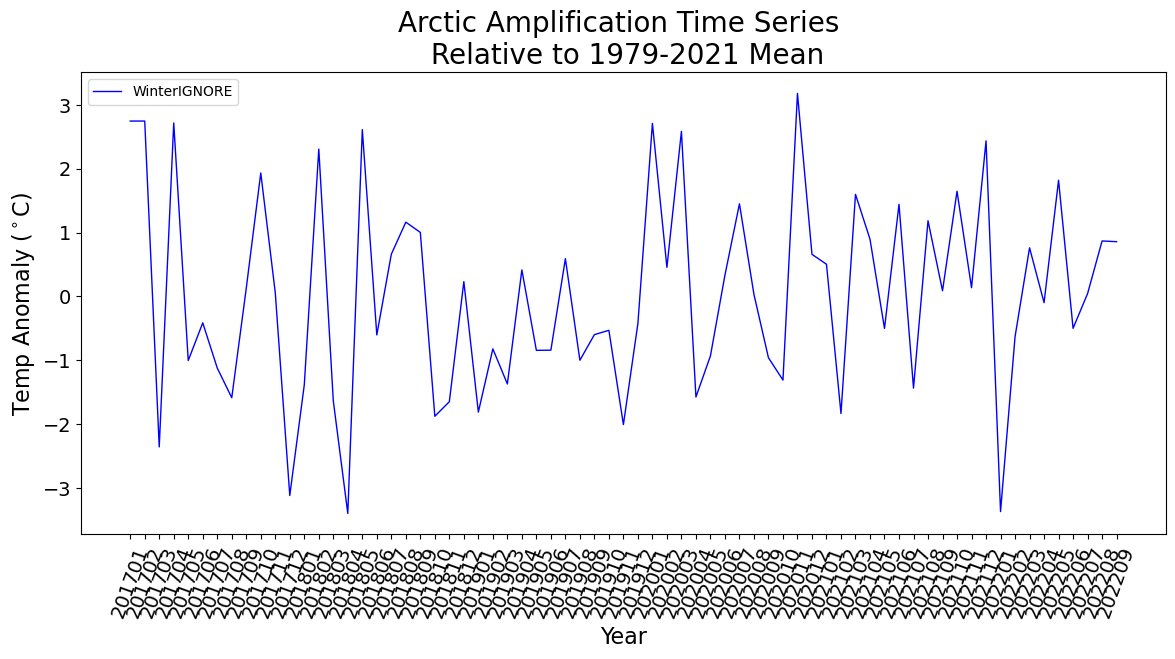

In [971]:
import matplotlib.pyplot as plt

## Create figure of a particular size
fig = plt.figure(figsize=(14, 6))

## TS Karl
# add plots for TS Karl windspeed
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(time_plot, anom_plot, label='WinterIGNORE', color='blue',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(years, spring, label='Spring', color='green',linewidth=1, markersize = 6) # , marker='o'
# ax1.plot(years, summer, label='Summer', color='red',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(years, fall, label='Fall', color='purple',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(years, annual, label='Annual', color='black',linewidth=2, linestyle='--', markersize = 6) #, marker='o'


ax1.set_title('Arctic Amplification Time Series \n Relative to 1979-2021 Mean', size = 20)
ax1.set_xlabel('Year', size = 16)
ax1.set_ylabel('Temp Anomaly ($^\circ$C)', size = 16)
ax1.tick_params(axis='x', labelrotation = 70, labelsize=14)
ax1.tick_params(axis='y',  labelsize=14)

ax1.legend(loc='upper left')

In [1005]:
# for each season
# try averageing anomaly and not doing std
# CAN CHANGE _ANOMALY VAR TO PLOT JUST TEMPS TO SEE IT


def season_yr(yr):
    df_final[df_final['temp_2m[C]'].isna()]

    df_for_measuring = df_final[['year', 'month','temp_2m[C]_anomaly']][df_final['year'] == yr]
    # df_for_measuring = df_for_measuring[~df_for_measuring['temp_2m[C]_anomaly'].isna()]
    df_cts = df_for_measuring.groupby(['year', 'month']).mean()
    df_cts.reset_index(inplace=True)
    df_cts.rename(columns = {'temp_2m[C]_anomaly':'mean_anomaly'}, inplace = True)


    df_for_normalization = df_final[['year', 'temp_2m[C]_anomaly', 'month']][df_final['year'] == yr]
    df_for_normalization = df_for_normalization[~df_for_normalization['temp_2m[C]_anomaly'].isna()]
    df_norm = df_for_normalization.groupby(['year','month' ]).count()
    df_norm.reset_index(inplace=True)
    df_norm.rename(columns = {'temp_2m[C]_anomaly':'count_totalyear'}, inplace = True)


    mgd = df_cts.merge(df_norm, on = ['year', 'month'], how = 'inner')
    # mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

    mgd['yearseas'] = mgd['month']
    
    time_plot = mgd['yearseas']
    anom_plot = mgd['mean_anomaly']
    
    return time_plot, anom_plot

mos_2017, anom_2017= season_yr('2017')
mos_2018, anom_2018= season_yr('2018')
mos_2019, anom_2019= season_yr('2019')
mos_2020, anom_2020= season_yr('2020')
mos_2021, anom_2021= season_yr('2021')
mos_2022, anom_2022= season_yr('2022')


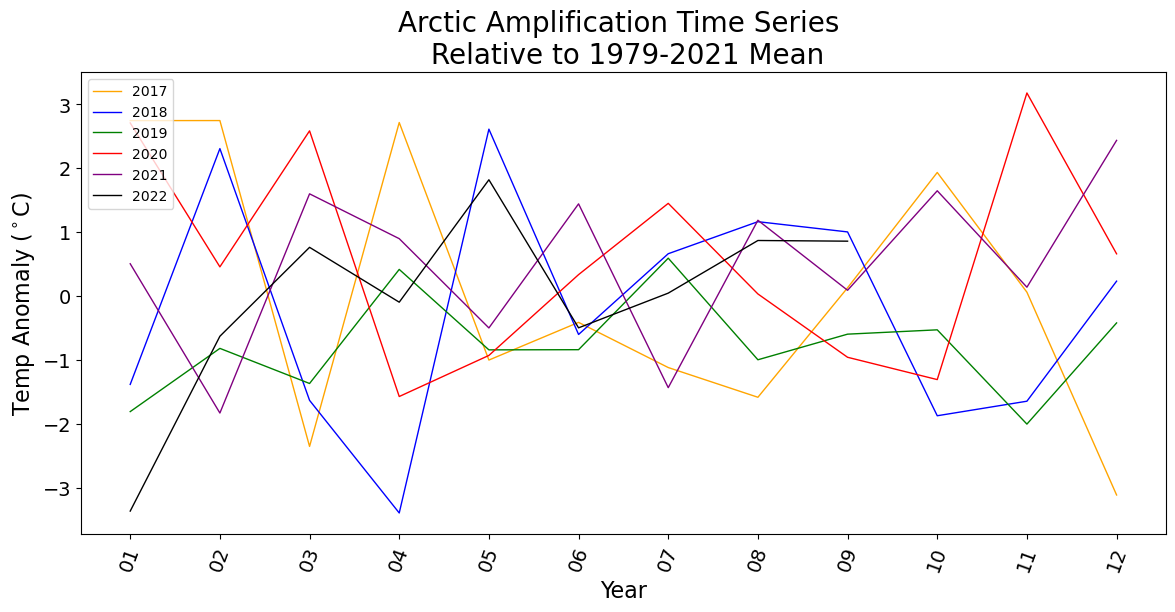

In [1006]:
import matplotlib.pyplot as plt

## Create figure of a particular size
fig = plt.figure(figsize=(14, 6))

## TS Karl
# add plots for TS Karl windspeed
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(mos_2018, anom_2017, label='2017', color='orange',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(mos_2018, anom_2018, label='2018', color='blue',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(mos_2019, anom_2019, label='2019', color='green',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(mos_2020, anom_2020, label='2020', color='red',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(mos_2021, anom_2021, label='2021', color='purple',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(mos_2022, anom_2022, label='2022', color='black',linewidth=1, markersize = 6) #, marker='o'

# ax1.plot(years, spring, label='Spring', color='green',linewidth=1, markersize = 6) # , marker='o'
# ax1.plot(years, summer, label='Summer', color='red',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(years, fall, label='Fall', color='purple',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(years, annual, label='Annual', color='black',linewidth=2, linestyle='--', markersize = 6) #, marker='o'


ax1.set_title('Arctic Amplification Time Series \n Relative to 1979-2021 Mean', size = 20)
ax1.set_xlabel('Year', size = 16)
ax1.set_ylabel('Temp Anomaly ($^\circ$C)', size = 16)
ax1.tick_params(axis='x', labelrotation = 70, labelsize=14)
ax1.tick_params(axis='y',  labelsize=14)

ax1.legend(loc='upper left')

In [977]:
# for each season
# try averageing anomaly and not doing std

def season_yr(seas):
    df_final[df_final['temp_2m[C]'].isna()]

    df_for_measuring = df_final[['year', 'season','temp_2m[C]_anomaly']][df_final['season'] == seas]
    df_for_measuring = df_for_measuring[~df_for_measuring['temp_2m[C]_anomaly'].isna()]
    df_cts = df_for_measuring.groupby(['year', 'season']).mean()
    df_cts.reset_index(inplace=True)
    df_cts.rename(columns = {'temp_2m[C]_anomaly':'mean_anomaly'}, inplace = True)


    df_for_normalization = df_final[['year', 'temp_2m[C]_anomaly', 'season']][df_final['season'] == seas]
    df_for_normalization = df_for_normalization[~df_for_normalization['temp_2m[C]_anomaly'].isna()]
    df_norm = df_for_normalization.groupby(['year','season' ]).count()
    df_norm.reset_index(inplace=True)
    df_norm.rename(columns = {'temp_2m[C]_anomaly':'count_totalyear'}, inplace = True)


    mgd = df_cts.merge(df_norm, on = ['year', 'season'], how = 'inner')
    # mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

    mgd['yearseas'] = mgd['year']+mgd['season']
    
    time_plot = mgd['yearseas']
    anom_plot = mgd['mean_anomaly']
    
    return time_plot, anom_plot

jja_time, jja_anom = season_yr('JJA')
print(type(jja_time))
print(jja_anom)

<class 'pandas.core.series.Series'>
0   -1.051097
1    0.417331
2   -0.411954
3    0.607629
4    0.386541
5    0.144525
Name: mean_anomaly, dtype: float64


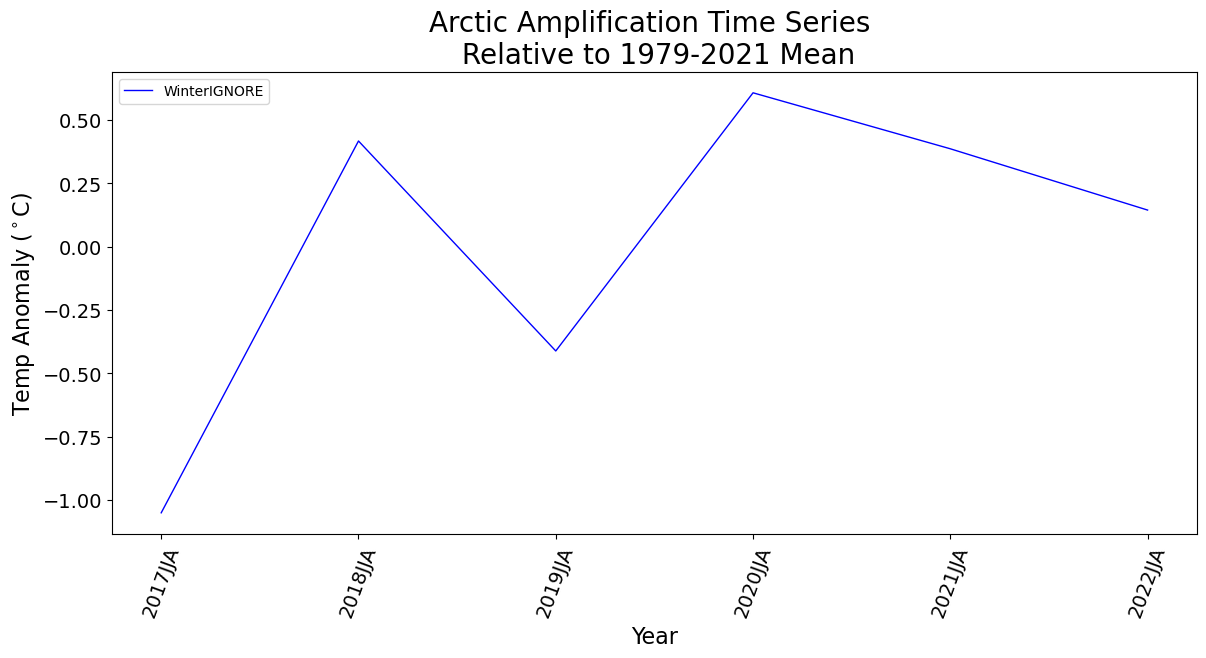

In [978]:
import matplotlib.pyplot as plt

## Create figure of a particular size
fig = plt.figure(figsize=(14, 6))

## TS Karl
# add plots for TS Karl windspeed
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(jja_time, jja_anom, label='WinterIGNORE', color='blue',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(years, spring, label='Spring', color='green',linewidth=1, markersize = 6) # , marker='o'
# ax1.plot(years, summer, label='Summer', color='red',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(years, fall, label='Fall', color='purple',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(years, annual, label='Annual', color='black',linewidth=2, linestyle='--', markersize = 6) #, marker='o'


ax1.set_title('Arctic Amplification Time Series \n Relative to 1979-2021 Mean', size = 20)
ax1.set_xlabel('Year', size = 16)
ax1.set_ylabel('Temp Anomaly ($^\circ$C)', size = 16)
ax1.tick_params(axis='x', labelrotation = 70, labelsize=14)
ax1.tick_params(axis='y',  labelsize=14)

ax1.legend(loc='upper left')

In [965]:
# try averageing anomaly and not doing std

df_final[df_final['temp_2m[C]'].isna()]

df_for_measuring = df_final[['year', 'temp_2m[C]_anomaly']][(df_final['station'] == 'BRON') & (df_final['season'] == 'SON')]
df_for_measuring = df_for_measuring[~df_for_measuring['temp_2m[C]_anomaly'].isna()]
df_cts = df_for_measuring.groupby(['year']).mean()
df_cts.reset_index(inplace=True)
df_cts.rename(columns = {'temp_2m[C]_anomaly':'mean_anomaly'}, inplace = True)


df_for_normalization = df_final[['year', 'temp_2m[C]_anomaly']][(df_final['station'] == 'BRON') & (df_final['season'] == 'SON')]
df_for_normalization = df_for_normalization[~df_for_normalization['temp_2m[C]_anomaly'].isna()]
df_norm = df_for_normalization.groupby(['year', ]).count()
df_norm.reset_index(inplace=True)
df_norm.rename(columns = {'temp_2m[C]_anomaly':'count_totalyear'}, inplace = True)


mgd = df_cts.merge(df_norm, on = 'year', how = 'inner')
# mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

mgd.head()

,year,mean_anomaly,count_totalyear
0,2017,1.214505,80
1,2018,-1.018781,91
2,2019,-0.786531,91
3,2020,0.358092,91
4,2021,0.444198,91


In [958]:
# try averageing anomaly and not doing std
#BRONX

df_final[df_final['temp_2m[C]'].isna()]

df_for_measuring = df_final[['year', 'temp_2m[C]_anomaly', 'season']][df_final['station'] == 'BRON']
df_for_measuring = df_for_measuring[~df_for_measuring['temp_2m[C]_anomaly'].isna()]
df_cts = df_for_measuring.groupby(['year', 'season']).mean()
df_cts.reset_index(inplace=True)
df_cts.rename(columns = {'temp_2m[C]_anomaly':'mean_anomaly'}, inplace = True)


df_for_normalization = df_final[['year', 'temp_2m[C]_anomaly', 'season']][df_final['station'] == 'BRON']
df_for_normalization = df_for_normalization[~df_for_normalization['temp_2m[C]_anomaly'].isna()]
df_norm = df_for_normalization.groupby(['year', 'season']).count()
df_norm.reset_index(inplace=True)
df_norm.rename(columns = {'temp_2m[C]_anomaly':'count_totalyear'}, inplace = True)


mgd = df_cts.merge(df_norm, on = ['year', 'season'], how = 'inner')
# mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

mgd

,year,season,mean_anomaly,count_totalyear
0,2017,DJF,-2.417792,31
1,2017,SON,1.214505,80
2,2018,DJF,0.280631,90
3,2018,JJA,-0.022964,92
4,2018,MAM,-0.709127,92
5,2018,SON,-1.018781,91
6,2019,DJF,-0.706916,90
7,2019,JJA,-0.146702,92
8,2019,MAM,-0.287453,92
9,2019,SON,-0.786531,91


## For presentation: 
- Not seeing much in terms of increased number of anomalous days, so didnt get to corrleating them
    - Could be due to how I am defining anomaly
- plan to look into by station more
## Count cold anomaly v warm anomaly by season by year?
## Can I even be going on average?? Need to do by site? I guess when doing std count its okay to aggregate
## DJF messed up
## Can look at half standard deviations away


In [989]:
# fractional std away
df_final = df[['date', 'monthday', 'station', 'temp_2m[C]']].merge(b[['monthday', 'station', 'mean', 'std']], how='inner', left_on = ['monthday', 'station'], right_on=['monthday', 'station'])
df_final.rename(columns = {'mean':'temp_2m[C]_mean', 'std':'temp_2m[C]_std'}, inplace = True)
df_final['year'] =  df_final['date'].astype(str).str[0:4]
df_final['month'] =  df_final['date'].astype(str).str[5:7]
season_list = []
months = df_final['month'].to_list()
for mo in months:
    if mo in ['12','01','02']:
        season_list.append('DJF')
    elif mo in ['03','04','05']:
        season_list.append('MAM')
    elif mo in ['06','07','08']:
        season_list.append('JJA')
    else:
        season_list.append('SON')
df_final['season'] = season_list
df_final['temp_2m[C]_anomaly'] = df_final['temp_2m[C]'] - df_final['temp_2m[C]_mean']
df_final['stds_away'] = abs(df_final['temp_2m[C]_anomaly'])/df_final['temp_2m[C]_std']

In [992]:
# try averageing anomaly and not doing std

df_final[df_final['temp_2m[C]'].isna()]

df_for_measuring = df_final[['year', 'stds_away']]
df_for_measuring = df_for_measuring[~df_for_measuring['stds_away'].isna()]
df_cts = df_for_measuring.groupby(['year']).mean()
df_cts.reset_index(inplace=True)
df_cts.rename(columns = {'stds_away':'mean_std_away'}, inplace = True)


df_for_normalization = df_final[['year', 'stds_away']]
df_for_normalization = df_for_normalization[~df_for_normalization['stds_away'].isna()]
df_norm = df_for_normalization.groupby(['year', ]).count()
df_norm.reset_index(inplace=True)
df_norm.rename(columns = {'stds_away':'mean_std_away'}, inplace = True)


mgd = df_cts.merge(df_norm, on = 'year', how = 'inner')
# mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

mgd

# NO EVIDENCE OF INCREASE STD AWAY!

,year,mean_std_away_x,mean_std_away_y
0,2017,0.838566,43121
1,2018,0.826421,45844
2,2019,0.735613,45946
3,2020,0.809524,46021
4,2021,0.781414,45856
5,2022,0.789469,32229


In [998]:
# try averageing anomaly and not doing std
def avgg(seas):
    df_final[df_final['temp_2m[C]'].isna()]

    df_for_measuring = df_final[['year', 'season', 'stds_away']][df_final['season'] == seas]
    df_for_measuring = df_for_measuring[~df_for_measuring['stds_away'].isna()]
    df_cts = df_for_measuring.groupby(['year', 'season']).mean()
    df_cts.reset_index(inplace=True)
    df_cts.rename(columns = {'stds_away':'mean_std_away'}, inplace = True)


    df_for_normalization = df_final[['year', 'stds_away', 'season']][df_final['season'] == seas]
    df_for_normalization = df_for_normalization[~df_for_normalization['stds_away'].isna()]
    df_norm = df_for_normalization.groupby(['year', 'season' ]).count()
    df_norm.reset_index(inplace=True)
    df_norm.rename(columns = {'stds_away':'ct_std_away'}, inplace = True)


    mgd = df_cts.merge(df_norm, on = ['year', 'season'], how = 'inner')
    # mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

    return mgd['year'], mgd['mean_std_away']

timedjf, valdjf = avgg('DJF')
timemam, valmam = avgg('MAM')
timejja, valjja = avgg('JJA')
timeson, valson = avgg('SON')

In [1000]:
valson

0    0.866624
1    0.902556
2    0.714621
3    0.904489
4    0.629077
5    0.489009
Name: mean_std_away, dtype: float64

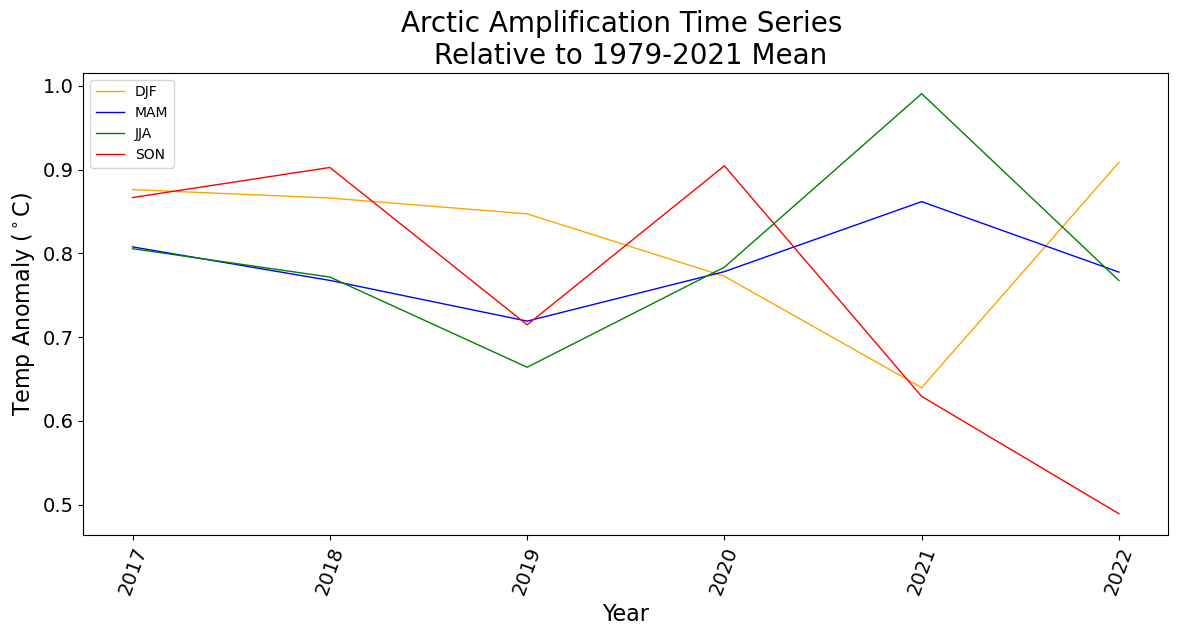

In [1001]:
import matplotlib.pyplot as plt

## Create figure of a particular size
fig = plt.figure(figsize=(14, 6))

## TS Karl
# add plots for TS Karl windspeed
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(timedjf, valdjf, label='DJF', color='orange',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(timemam, valmam, label='MAM', color='blue',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(timejja, valjja, label='JJA', color='green',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(timeson, valson, label='SON', color='red',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(mos_2021, anom_2021, label='2021', color='purple',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(mos_2022, anom_2022, label='2022', color='black',linewidth=1, markersize = 6) #, marker='o'

# ax1.plot(years, spring, label='Spring', color='green',linewidth=1, markersize = 6) # , marker='o'
# ax1.plot(years, summer, label='Summer', color='red',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(years, fall, label='Fall', color='purple',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(years, annual, label='Annual', color='black',linewidth=2, linestyle='--', markersize = 6) #, marker='o'


ax1.set_title('Arctic Amplification Time Series \n Relative to 1979-2021 Mean', size = 20)
ax1.set_xlabel('Year', size = 16)
ax1.set_ylabel('Temp Anomaly ($^\circ$C)', size = 16)
ax1.tick_params(axis='x', labelrotation = 70, labelsize=14)
ax1.tick_params(axis='y',  labelsize=14)

ax1.legend(loc='upper left')

In [ ]:
# try averageing anomaly and not doing std

df_final[df_final['temp_2m[C]'].isna()]

df_for_measuring = df_final[['year', 'temp_2m[C]_anomaly', 'season']]
df_for_measuring = df_for_measuring[~df_for_measuring['temp_2m[C]_anomaly'].isna()]
df_cts = df_for_measuring.groupby(['year', 'season']).mean()
df_cts.reset_index(inplace=True)
df_cts.rename(columns = {'temp_2m[C]_anomaly':'mean_anomaly'}, inplace = True)


df_for_normalization = df_final[['year', 'temp_2m[C]_anomaly', 'season']]
df_for_normalization = df_for_normalization[~df_for_normalization['temp_2m[C]_anomaly'].isna()]
df_norm = df_for_normalization.groupby(['year', 'season']).count()
df_norm.reset_index(inplace=True)
df_norm.rename(columns = {'temp_2m[C]_anomaly':'count_totalyear'}, inplace = True)


mgd = df_cts.merge(df_norm, on = ['year', 'season'], how = 'inner')
# mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

In [933]:
df_cts['temp_2m[C]_anomaly'].sum()

259017

In [890]:
round((1.974306+1.556117),2)/6.352793

0.5556611084290012

In [898]:
df_final

,date,monthday,station,temp_2m[C],temp_2m[C]_mean,temp_2m[C]_std,year,month,season,temp_2m[C]_anomaly,greater_than_x_stds_away
0,2017-01-01,01-01,ADDI,0.126042,-3.360558,6.257776,2017,01,DJF,3.486600,0.0
1,2018-01-01,01-01,ADDI,-16.729861,-3.360558,6.257776,2018,01,DJF,-13.369303,2.0
2,2019-01-01,01-01,ADDI,4.503125,-3.360558,6.257776,2019,01,DJF,7.863683,1.0
3,2020-01-01,01-01,ADDI,-2.948264,-3.360558,6.257776,2020,01,DJF,0.412294,0.0
4,2021-01-01,01-01,ADDI,-4.305903,-3.360558,6.257776,2021,01,DJF,-0.945345,0.0
...,...,...,...,...,...,...,...,...,...,...,...
262327,2018-12-31,12-31,YORK,-0.008333,-1.556117,6.352793,2018,12,DJF,1.547784,0.0
262328,2019-12-31,12-31,YORK,2.273264,-1.556117,6.352793,2019,12,DJF,3.829381,0.0
262329,2020-12-31,12-31,YORK,1.974306,-1.556117,6.352793,2020,12,DJF,3.530423,0.0
262330,2021-12-31,12-31,YORK,5.020139,-1.556117,6.352793,2021,12,DJF,6.576256,1.0


In [862]:
df_final[90000:90006]

,date,monthday,station,temp_2m[C],temp_2m[C]_mean,temp_2m[C]_relative_std,year,month,season
90000,2017-03-21,03-21,ELMI,4.872917,2.831659,5.248027,2017,03,MAM
90001,2018-03-21,03-21,ELMI,-1.964236,2.831659,5.248027,2018,03,MAM
90002,2019-03-21,03-21,ELMI,5.068403,2.831659,5.248027,2019,03,MAM
90003,2020-03-21,03-21,ELMI,0.658333,2.831659,5.248027,2020,03,MAM
90004,2021-03-21,03-21,ELMI,5.608333,2.831659,5.248027,2021,03,MAM
90005,2022-03-21,03-21,ELMI,6.518403,2.831659,5.248027,2022,03,MAM


In [846]:
len(g)

262332

In [843]:
g = df_final['month'].to_list()
h = g[61112:61117]

for j in g:
    print(h)
    if j in ['03','04', '05']:
        print('hi!')

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [841]:
g[61112:61117]

['05', '05', '05', '05', '05']

In [832]:
listy = ['05', '09']
ff = '05'
if ff in listy:
    print('good!')

good!


In [856]:
df_final[61112:61117]

,date,monthday,station,temp_2m[C],temp_2m[C]_mean,temp_2m[C]_relative_std,year,month,season
61112,2019-05-03,05-03,COLD,11.500694,8.562117,4.354578,2019,05,MAM
61113,2020-05-03,05-03,COLD,13.892014,8.562117,4.354578,2020,05,MAM
61114,2021-05-03,05-03,COLD,11.447917,8.562117,4.354578,2021,05,MAM
61115,2022-05-03,05-03,COLD,10.588194,8.562117,4.354578,2022,05,MAM
61116,2017-05-04,05-04,COLD,6.448611,8.585964,4.370676,2017,05,MAM


In [480]:
df['anomaly_temp_2m[C]'] = df_merge['temp_2m[C]'] - df_merge['rel_day_temp_2m[C]']

In [481]:
df_merge

,date,monthday,station,temp_2m[C],rel_day_temp_2m[C]_count,rel_day_temp_2m[C],anomaly_temp_2m[C]
0,2017-01-01,01-01,ADDI,0.126042,6,-3.360558,3.486600
1,2018-01-01,01-01,ADDI,-16.729861,6,-3.360558,-13.369303
2,2019-01-01,01-01,ADDI,4.503125,6,-3.360558,7.863683
3,2020-01-01,01-01,ADDI,-2.948264,6,-3.360558,0.412294
4,2021-01-01,01-01,ADDI,-4.305903,6,-3.360558,-0.945345
...,...,...,...,...,...,...,...
262327,2018-12-31,12-31,YORK,-0.008333,5,-1.556117,1.547784
262328,2019-12-31,12-31,YORK,2.273264,5,-1.556117,3.829381
262329,2020-12-31,12-31,YORK,1.974306,5,-1.556117,3.530423
262330,2021-12-31,12-31,YORK,5.020139,5,-1.556117,6.576256


## REFERENCE CODE ONLY
#### Ignore..


In [109]:
# call on a coordinate
nysm_ds.station

# call on a varibale
nysm_ds['temp_2m [degC]']

<xarray.DataArray 'temp_2m [degC]' (station: 126, time: 8929)>
array([[23.3, 22.7, 22.5, ..., 18.2, 18.2, 18.2],
       [21.3, 20.4, 19.7, ..., 16.8, 16.5, 16.4],
       [24.1, 24. , 24. , ..., 22.6, 22.6, 22.5],
       ...,
       [24.7, 24.2, 23.5, ..., 14.3, 14.3, 14.4],
       [23.8, 22.9, 22.5, ..., 22.1, 21.8, 21.8],
       [22.8, 22.2, 21.8, ..., 22.9, 22.8, 22.6]])
Coordinates:
  * station  (station) object 'ADDI' 'ANDE' 'BATA' ... 'WHIT' 'WOLC' 'YORK'
  * time     (time) datetime64[ns] 2020-07-31T23:50:00 ... 2020-08-31T23:55:00

In [ ]:
nysm_ds['temp_2m [degC]'].shape

In [29]:
# REFERENCE ONLY
# "data array" . mean ("dimension to average across"... eliminating that dim completely, it's averaged out if left blank, will average over everything to give ONE mean value)
# produces another array whose length depends on what you averaged over!

# example 1
avg_temp_by_day = nysm_ds['temp_2m [degC]'].mean('station')
print(avg_temp_by_day.shape)

# example 2
avg_temp_by_station = nysm_ds['temp_2m [degC]'].mean('time')
print(avg_temp_by_station.shape)

(8929,)
(126,)


In [39]:
# this is just like SQL - using all data, but group certain rows together based on common (i.e. season) and then still want to average over the time dimension so that dim is gone and we're left with station only
test1 = nysm_ds.groupby("time.season").mean("time")

/knight/anaconda_aug22/envs/aug22_env/lib/python3.10/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in true_divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


In [43]:
test1

<xarray.Dataset>
Dimensions:                                (station: 126, date: 32)
Coordinates:
  * station                                (station) object 'ADDI' ... 'YORK'
  * date                                   (date) object 2020-07-31 ... 2020-...
Data variables: (12/28)
    temp_2m [degC]                         (station, date) float64 23.3 ... 1...
    temp_9m [degC]                         (station, date) float64 23.5 ... 1...
    relative_humidity [percent]            (station, date) float64 57.1 ... 80.6
    precip_incremental [mm]                (station, date) float64 0.0 ... 0.0
    precip_local [mm]                      (station, date) float64 0.0 ... 0....
    precip_max_intensity [mm/min]          (station, date) float64 0.0 ... 0.0
    ...                                     ...
    soil_temp_05cm [degC]                  (station, date) float64 22.1 ... 1...
    soil_temp_25cm [degC]                  (station, date) float64 20.1 ... 2...
    soil_temp_50cm [degC]                  (station, date) float64 19.1 ... 2...
    soil_moisture_05cm [m^3/m^3]           (station, date) float64 0.08 ... 0...
    soil_moisture_25cm [m^3/m^3]           (station, date) float64 0.2 ... 0....
    soil_moisture_50cm [m^3/m^3]           (station, date) float64 0.27 ... 0.21

In [38]:
test2= nysm_ds.groupby("time.season")
type(test2)

xarray.core.groupby.DatasetGroupBy

In [10]:
ds_sub = nysm_ds.sel(time=nysm_ds.time.dt.month.isin([4]))

In [13]:
nysm_ds.time.dt.date

<xarray.DataArray 'date' (time: 8929)>
array([datetime.date(2020, 7, 31), datetime.date(2020, 8, 1),
       datetime.date(2020, 8, 1), ..., datetime.date(2020, 8, 31),
       datetime.date(2020, 8, 31), datetime.date(2020, 8, 31)],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2020-07-31T23:50:00 ... 2020-08-31T23:55:00

In [99]:
# REFERENCE -- Check that this rolling average is working correctly, not getting mixed up by sites or anything

# SUBSET DATASET: https://stackoverflow.com/questions/38846323/python-xarray-dataset-sel-select-multiple-values-along-one-dimension
# way 1
y = ds_avg_by_site_date.where(ds_avg_by_site_date.station=='WOLC', drop = True)#, "date" :'2020-08-06'})
y

# way 2 (using sel and also datetime issue)
# Using .sel (datetime format issue..)
# g = ds_avg_by_site_date.sel(ds_avg_by_site_date.date == dt.date(2020, 7, 31)) # DATETIME ISSUE
# g

# print out the temps for WOLC then avg in cell below to make sure it works
y["temp_2m [degC]"]

<xarray.DataArray 'temp_2m [degC]' (station: 1, date: 32)>
array([[23.8       , 22.29583333, 25.55173611, 23.64409722, 20.59097222,
        20.34097222, 18.16458333, 19.39201389, 21.21284722, 22.58715278,
        25.67291667, 26.40486111, 22.86041667, 21.67986111, 22.54895833,
        22.99444444, 22.41805556, 20.709375  , 19.25034722, 18.06284722,
        18.01909722, 20.62152778, 22.36423611, 23.75208333, 24.45972222,
        23.28298611, 18.26666667, 20.33854167, 20.16666667, 21.65798611,
        18.71840278, 17.40381944]])
Coordinates:
  * station  (station) object 'WOLC'
  * date     (date) object 2020-07-31 2020-08-01 ... 2020-08-30 2020-08-31

In [8]:
num = 23.8 +22.29583333+25.55173611+23.64409722+20.59097222
num/5

23.176527776

In [9]:
# check that this was the first non nan value for WOLC
# rolling_5day_avg
rolling_5day_avg.where(rolling_5day_avg.station=='WOLC', drop = True) # confirmed! the first value is 23.18

<xarray.Dataset>
Dimensions:                                (station: 1, date: 32)
Coordinates:
  * station                                (station) object 'WOLC'
  * date                                   (date) object 2020-07-31 ... 2020-...
Data variables: (12/28)
    temp_2m [degC]                         (station, date) float64 nan ... nan
    temp_9m [degC]                         (station, date) float64 nan ... nan
    relative_humidity [percent]            (station, date) float64 nan ... nan
    precip_incremental [mm]                (station, date) float64 nan ... nan
    precip_local [mm]                      (station, date) float64 nan ... nan
    precip_max_intensity [mm/min]          (station, date) float64 nan ... nan
    ...                                     ...
    soil_temp_05cm [degC]                  (station, date) float64 nan ... nan
    soil_temp_25cm [degC]                  (station, date) float64 nan ... nan
    soil_temp_50cm [degC]                  (station, date) float64 nan ... nan
    soil_moisture_05cm [m^3/m^3]           (station, date) float64 nan ... nan
    soil_moisture_25cm [m^3/m^3]           (station, date) float64 nan ... nan
    soil_moisture_50cm [m^3/m^3]           (station, date) float64 nan ... nan

#### Reference only 11/27: manually creating rolling dates read in

In [ ]:
# method 1
datetime_mmyy = datetime.strptime('02-04', '%m-%d')
datetime_mmyy

In [ ]:
# back to method 1
def date_string(date_val):
    return f"{'{:02d}'.format(date_val.month)}{'{:02d}'.format(date_val.day)}"


def read_csv_rolling(centerdate, numdays): # change numdays to rolling_half
    dateList = []
    for x in range (0, numdays+1):
        if x == 0:
            center_date = date_string(centerdate)
            dateList.append(center_date)
        else:
            prior_date = date_string(centerdate - timedelta(days = x))
            dateList.append(prior_date)
            next_date = date_string(centerdate + timedelta(days = x))
            dateList.append(next_date)
    return dateList

day_range_read = read_csv_rolling(datetime_mmyy, 7)

print(day_range_read)
print(len(day_range_read))


In [ ]:
%%time 

li = []

for day in day_range_read:
    # list files for a given day, e.g. if day is 0204, this will list mesonet csv data for 20160204, 20170204, ... 20220204
    all_files = glob(f"{path}*{day}.csv")

    # for each file (year) in list, read in the data csv data and append it to outer list
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

nysm_data = pd.concat(li, axis=0, ignore_index=True)


In [ ]:
# method 1
# set station and time to be indices of the df so that the conversion to xarray dataset makes them coordinates
nysm_data = nysm_data.set_index(["station", "time"])

# convert to dataset
nysm_ds = nysm_data.to_xarray()

# convert time coordinate of the dataset to datetime format
# NOTE: must be executed twice (last subcomment here by Vinod: https://stackoverflow.com/questions/62572678/xarray-coords-conversion-to-datetime64)
nysm_ds["time"] = pd.DatetimeIndex(nysm_ds["time"].values)
nysm_ds["time"] = pd.DatetimeIndex(nysm_ds["time"].values)

nysm_ds

In [203]:
# issue subsetting slicing by dates

ds_avg_by_site_date.sel(station = 'BATA', date in (datetime.date(2017, 1, 1), datetime.date(2017, 1, 3)))#['temp_2m[C]'].values

SyntaxError: positional argument follows keyword argument (3043326369.py, line 3)

In [ ]:
import xarray as xr
import numpy as np
data = xr.DataArray([1, 2, 3], dims='x', coords={'x': [10, 20, 30]})
# data
data_newcoord = data.assign_coords(y='newvaluee')
# data
data_expanded = data_newcoord.expand_dims('y')
data_expanded
# print(data_expanded)

In [ ]:
nysm_ds["time.month"]

In [ ]:
m = ds['date.month']
d = ds['date.day']
t = ds['date.date']


# day_ = m+d
# day_

mo_day = []
for i in range(0, len(ds['date'])):
    day = f"{'{:02d}'.format(ds['date.month'][i].values.item())}{'{:02d}'.format(ds['date.day'][i].values.item())}"
    mo_day.append(day)


In [ ]:
ds['yeartry'] = ds["date.year"]
ds['monttry'] = ds["date.month"]
ds['daytry'] = ds["date.day"]

ds2 = ds.assign_coords(coor_yr=ds["date.year"],coor_mo=ds["date.month"],coor_day=ds["date.day"])



In [ ]:
ds2.swap_dims({'date':'yeartry' }).drop('date')

In [ ]:
import xarray as xr

data_newcoord = data.assign_coords(y='coord_value')
data_expanded = data_newcoord.expand_dims('y')
print(data_expanded)

dsavg2 = ds.mean(dim="date.year", skipna=True)

In [53]:
ds

<xarray.Dataset>
Dimensions:             (station: 126, year: 2, date: 730)
Coordinates:
  * station             (station) object 'ADDI' 'ANDE' 'BATA' ... 'WOLC' 'YORK'
  * year                (year) object '2017' '2018'
  * date                (date) datetime64[ns] 2017-01-01 ... 2018-12-31
Data variables:
    temp_2m[C]          (station, year, date) float64 0.126 -1.302 ... -0.008333
    rolling_temp_2m[C]  (station, year, date) float64 nan nan nan ... nan nan

In [60]:
ds["date.month"]

<xarray.DataArray 'month' (date: 730)>
array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12,
...
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12])
Coordinates:
  * date     (date) datetime64[ns] 2017-01-01 2017-01-02 ... 2018-12-31

In [54]:
ds_new = ds


In [ ]:
ds_new.assign_coords(mo_day=(((ds.date + 180) % 360) - 180))

#### Ideas for averageing over hyear which ended up doing in df
#### split the date which is currently year_month_day into 1)year and 2) month_day 
    - then I can average over year
#### OR if there is a way to "call on" the month_day from the date coordinate (like we did in group by functions above) we can use the groupby way

# work with group by and std and resetting columns

In [ ]:
df_anom_monthday = df_sub.groupby(['monthday', 'station']).agg(['count','mean', lambda x: np.std(x, ddof=0)])
df_anom_monthday.reset_index(inplace=True)
#rename columns 
mi = df_anom_monthday.columns
ind = pd.Index([e[0] + e[1] for e in mi.tolist()])
df_anom_monthday.columns = ind
df_anom_monthday.rename(columns = {'rolling_temp_2m[C]mean':'rel_day_temp_2m[C]'}, inplace = True)
df_anom_monthday.rename(columns = {'rolling_temp_2m[C]<lambda_0>':'rel_day_temp_2m[C]_std'}, inplace = True)
df_anom_monthday.rename(columns = {'rolling_temp_2m[C]count':'rel_day_temp_2m[C]_count'}, inplace = True)
print(df_anom_monthday.head())
# print(f"count month|stations with no relative temp (i.e. nan for all 6 years at that station and day) -- count {len(df_anom_monthday['rel_day_temp_2m[C]'][df_anom_monthday['rel_day_temp_2m[C]'].isna()])}")

# Note: for 1/1, there should be 5 years (not 6!) b/c the first year of data 2017 wouldn't have prior 7 days of data


# helpful print statements
print(len(df_anom_monthday))

# count the number of station|days where <5 years
print(df_anom_monthday[df_anom_monthday['rel_day_temp_2m[C]_count'] > 5].shape)
print(df_anom_monthday[df_anom_monthday['rel_day_temp_2m[C]_count'] > 4].shape)
print(df_anom_monthday[df_anom_monthday['rel_day_temp_2m[C]_count'] == 0])

df_merge = df[['date', 'monthday', 'station', 'temp_2m[C]']].merge(df_anom_monthday, how='inner', left_on = ['monthday', 'station'], right_on=['monthday', 'station'])
# df_final= df_merge.merge(df_count_monthday, how='inner', left_on = ['monthday', 'station'], right_on=['monthday', 'station'])

In [ ]:
mi = df_anom_monthday.columns
ind = pd.Index([e[0] + e[1] for e in mi.tolist()])
ind

In [ ]:


v = df[(df['station'] =='BATA') & (df['monthday'] == '01-24')]['rolling_temp_2m[C]'].to_list()
v

In [ ]:
np.std(v, ddof = 0)
np.std(v, ddof = 1) # pandas (if just do "std" in agg in group by... uses 1 delta degrees of freedom so divide by N-1. Point of doing n-1 is b/c our sample is different than pop so it's underestimating the variation in public, thus "fix" by making the std larger)
# https://stackoverflow.com/questions/47676250/pandas-agg-function-gives-different-results-for-numpy-std-vs-nanstd

In [ ]:
df_sub.head()
b = df_sub.groupby(['monthday', 'station']).agg({'rolling_temp_2m[C]_mean':'mean', 'sum_xi_sq':'sum', 'included':'count'}) # once I have multiple cols in my df should be able to do different things to each

b.reset_index(inplace=True)
b.rename(columns = {'rolling_temp_2m[C]_mean': 'mean','sum_xi_sq': 'sum' , 'included': 'ct'}, inplace = True)
# b.rename(columns = {'testcol':'var'}, inplace = True)

b['var_day'] = np.sqrt(b['sum']/(15*b['ct']) - b['mean'])

In [ ]:
# # wrong way on train
# def meansquare_x15(x): #  myfn has to aggregate values somehow b/c it's built in that it's taking in ROWS. Input to this function is a datafrme. When pairing this function with .agg, it knows to go through each row of df, this is buult in. Thus it is a necessaity that the output (return) of my function MUST AGGREGATE, i.e. sum, diff, mean, etc. Will get an error if not!
#     return sum((x**2)*15)

# def var_x15(x): #  myfn has to aggregate values somehow b/c it's built in that it's taking in ROWS. Input to this function is a datafrme. When pairing this function with .agg, it knows to go through each row of df, this is buult in. Thus it is a necessaity that the output (return) of my function MUST AGGREGATE, i.e. sum, diff, mean, etc. Will get an error if not!
#     return sum((x)*15)
    
# b = df_sub.groupby(['monthday', 'station']).agg({'rolling_temp_2m[C]_mean':meansquare_x15, 'rolling_temp_2m[C]_var':var_x15, 'included':'count'}) # once I have multiple cols in my df should be able to do different things to each

# b.reset_index(inplace=True)
# b.rename(columns = {'rolling_temp_2m[C]_mean': 'mean_squared_x15','rolling_temp_2m[C]_var':'var_x15' }, inplace = True)
# # b.rename(columns = {'testcol':'var'}, inplace = True)

# b['var_day'] = np.sqrt((b['mean_squared_x15']+b['var_x15'])/(15*b['included']))

